# 자연어 처리와 단어 벡터

이 노트북에서 자연어 처리 데이터셋(구텐베르크 프로젝트의 책) 정제하고 word2vec을 사용해 단어 벡터로 임베딩합니다.

**노트:** 이 전처리 단계의 일부나 전부가 후속 애플리케이션에 도움이 되거나 전혀 도움이 되지 않을 수 있습니다. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/11-1.natural_language_preprocessing.ipynb)

#### 라이브러리를 적재합니다.

In [1]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
%matplotlib inline

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 데이터를 적재합니다.

In [2]:
from nltk.corpus import gutenberg

In [3]:
len(gutenberg.fileids())

18

In [4]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [5]:
len(gutenberg.words())

2621613

In [6]:
gberg_sent_tokens = sent_tokenize(gutenberg.raw())

In [7]:
gberg_sent_tokens[0:6]

['[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.',
 "She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.",
 'Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.',
 "Sixteen years had Miss Taylor been in Mr. Woodhouse's family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.",
 'Between _them_ it was more the intimacy\nof sisters.',
 "Even before Miss Taylor had ceased to hold the nominal

In [8]:
gberg_sent_tokens[1]

"She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period."

In [9]:
word_tokenize(gberg_sent_tokens[1])

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'s",
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

In [10]:
word_tokenize(gberg_sent_tokens[1])[14]

'father'

In [11]:
# 개행 문자를 처리하고 문장과 단어를 한 번에 토큰화합니다.
gberg_sents = gutenberg.sents()

In [12]:
gberg_sents[0:6]

[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']'],
 ['VOLUME', 'I'],
 ['CHAPTER', 'I'],
 ['Emma',
  'Woodhouse',
  ',',
  'handsome',
  ',',
  'clever',
  ',',
  'and',
  'rich',
  ',',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  ',',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  ';',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  '-',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her',
  '.'],
 ['She',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  ',',
  'indulgent',
  'father',
  ';',
  'and',
  'had',
  ',',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  "'",
  's',
  'marriage',
  ',',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period',
  '.'],
 ['Her',
  'mother',
  'h

In [13]:
gberg_sents[4][14]

'father'

#### 한 문장을 전처리합니다.

##### 문장을 토큰화합니다.

In [14]:
gberg_sents[4]

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### 소문자로 바꿉니다.

In [15]:
[w.lower() for w in gberg_sents[4]]

['she',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### 불용어와 구둣점을 삭제합니다.

In [16]:
stpwrds = stopwords.words('english') + list(string.punctuation)

In [17]:
stpwrds

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
[w.lower() for w in gberg_sents[4] if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period']

##### 어간을 추출합니다.

In [19]:
stemmer = PorterStemmer()

In [20]:
[stemmer.stem(w.lower()) for w in gberg_sents[4] 
 if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughter',
 'affection',
 'indulg',
 'father',
 'consequ',
 'sister',
 'marriag',
 'mistress',
 'hous',
 'earli',
 'period']

##### 바이그램을 다룹니다.

In [21]:
phrases = Phrases(gberg_sents) # 디텍터 훈련

In [22]:
bigram = Phraser(phrases) # 더 효율적으로 문장을 변형하는 Phraser 객체를 만듭니다.

In [23]:
bigram.phrasegrams # 바이그램 횟수와 점수를 출력합니다.

{(b'two', b'daughters'): (19, 11.966813731181546),
 (b'her', b'sister'): (195, 17.7960829227865),
 (b"'", b's'): (9781, 31.066242737744524),
 (b'very', b'early'): (24, 11.01214147275924),
 (b'Her', b'mother'): (14, 13.529425062715127),
 (b'long', b'ago'): (38, 63.22343628984788),
 (b'more', b'than'): (541, 29.023584433996874),
 (b'had', b'been'): (1256, 22.306024648925288),
 (b'an', b'excellent'): (54, 39.063874851750626),
 (b'Miss', b'Taylor'): (48, 453.75918026073305),
 (b'very', b'fond'): (28, 24.134280468850747),
 (b'passed', b'away'): (25, 12.35053642325912),
 (b'too', b'much'): (173, 31.376002029426687),
 (b'did', b'not'): (935, 11.728416217142811),
 (b'any', b'means'): (27, 14.096964108090186),
 (b'wedding', b'-'): (15, 17.4695197740113),
 (b'Her', b'father'): (18, 13.129571562488772),
 (b'after', b'dinner'): (21, 21.5285481168817),
 (b'self', b'-'): (124, 47.79018053120332),
 (b'sixteen', b'years'): (12, 107.0461671612265),
 (b'five', b'years'): (42, 40.128755673408115),
 (b'ye

In [24]:
tokenized_sentence = "Jon lives in New York City".split()

In [25]:
tokenized_sentence

['Jon', 'lives', 'in', 'New', 'York', 'City']

In [26]:
bigram[tokenized_sentence]

['Jon', 'lives', 'in', 'New_York', 'City']

#### 말뭉치를 전처리합니다.

In [27]:
# Maas et al. (2001)에 따라
# - (감정을 표현하는) 불용어는 남겨 둡니다.
# - 어간 추출을 하지 않습니다(모델이 같은 어간을 갖는 단어의 비슷한 표현을 학습합니다).
lower_sents = []
for s in gberg_sents:
    lower_sents.append([w.lower() for w in s if w.lower()
                        not in list(string.punctuation)])

In [28]:
lower_sents[0:5]

[['emma', 'by', 'jane', 'austen', '1816'],
 ['volume', 'i'],
 ['chapter', 'i'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'and',
  'rich',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her'],
 ['she',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  'indulgent',
  'father',
  'and',
  'had',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  's',
  'marriage',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period']]

In [29]:
lower_bigram = Phraser(Phrases(lower_sents))

In [30]:
lower_bigram.phrasegrams # miss taylor, mr woodhouse, mr weston

{(b'two', b'daughters'): (19, 11.080802900992637),
 (b'her', b'sister'): (201, 16.93971298099339),
 (b'very', b'early'): (25, 10.516998773665177),
 (b'her', b'mother'): (253, 10.70812618607742),
 (b'long', b'ago'): (38, 59.226442015336005),
 (b'more', b'than'): (562, 28.529926612065935),
 (b'had', b'been'): (1260, 21.583193129694834),
 (b'an', b'excellent'): (58, 37.41859680854167),
 (b'sixteen', b'years'): (15, 131.42913000977515),
 (b'miss', b'taylor'): (48, 420.4340982546865),
 (b'mr', b'woodhouse'): (132, 104.19907841850323),
 (b'very', b'fond'): (30, 24.185726346489627),
 (b'passed', b'away'): (25, 11.751473221742694),
 (b'too', b'much'): (177, 30.36309017383541),
 (b'did', b'not'): (977, 10.846196223896685),
 (b'any', b'means'): (28, 14.294148100212627),
 (b'after', b'dinner'): (22, 18.60737125272944),
 (b'mr', b'weston'): (162, 91.63290824201266),
 (b'five', b'years'): (42, 37.66428596665674),
 (b'years', b'old'): (176, 48.599094446190286),
 (b'seven', b'years'): (53, 50.3345604

In [31]:
lower_bigram["jon lives in new york city".split()]

['jon', 'lives', 'in', 'new_york', 'city']

In [32]:
lower_bigram = Phraser(Phrases(lower_sents, 
                               min_count=32, threshold=64))
lower_bigram.phrasegrams

{(b'afar', b'off'): (52, 108.14220347465505),
 (b'burnt', b'offering'): (184, 297.524653753951),
 (b'burnt', b'offerings'): (86, 299.15702343127646),
 (b'buster', b'bear'): (142, 479.87410772225826),
 (b'captain', b'benwick'): (56, 241.49037086312987),
 (b'captain', b'wentworth'): (196, 529.8756608388247),
 (b'charles', b'hayter'): (33, 92.03437785214481),
 (b'chief', b'priests'): (65, 116.31947753846512),
 (b'colonel', b'brandon'): (132, 1313.0078125),
 (b'couldn', b't'): (89, 171.76138536935215),
 (b'cut', b'off'): (217, 129.60290535032792),
 (b'dare', b'say'): (115, 89.94000515807346),
 (b'de', b'grey'): (77, 603.2109624246722),
 (b'didn', b't'): (180, 220.51081560283686),
 (b'doesn', b't'): (53, 106.2634985949418),
 (b'don', b't'): (830, 250.30957446808512),
 (b'dr', b'bull'): (65, 680.7870294599019),
 (b'dr', b'middleton'): (40, 162.73103819257668),
 (b'drawing', b'room'): (49, 84.91494947493561),
 (b'farmer', b'brown'): (100, 386.05179596892236),
 (b'father', b'brown'): (207, 91.

In [33]:
clean_sents = []
for s in lower_sents:
    clean_sents.append(lower_bigram[s])

In [34]:
clean_sents[0:9]

[['emma', 'by', 'jane', 'austen', '1816'],
 ['volume', 'i'],
 ['chapter', 'i'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'and',
  'rich',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her'],
 ['she',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  'indulgent',
  'father',
  'and',
  'had',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  's',
  'marriage',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period'],
 ['her',
  'mother',
  'had',
  'died',
  'too',
  'long',
  'ago',
  'for',
  'her',
  'to',
  'have',
  'more',
  'than',
  'an',
 

In [35]:
clean_sents[6] 

['sixteen',
 'years',
 'had',
 'miss_taylor',
 'been',
 'in',
 'mr_woodhouse',
 's',
 'family',
 'less',
 'as',
 'a',
 'governess',
 'than',
 'a',
 'friend',
 'very',
 'fond',
 'of',
 'both',
 'daughters',
 'but',
 'particularly',
 'of',
 'emma']

#### word2vec 실행

In [36]:
# min_count 대신 max_vocab_size를 사용할 수 있습니다.
# model = Word2Vec(sentences=clean_sents, size=64, 
#                  sg=1, window=10, iter=5,
#                  min_count=10, workers=4)
# model.save('clean_gutenberg_model.w2v')

#### 모델을 살펴 봅니다.

In [37]:
# 코랩에서 실행할 경우 다음 코드를 실행합니다.
!wget https://git.io/Jt02A -O clean_gutenberg_model.w2v

--2021-02-02 01:38:02--  https://git.io/Jt02A
Resolving git.io (git.io)... 35.175.47.233, 52.206.211.104, 3.88.74.186, ...
Connecting to git.io (git.io)|35.175.47.233|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rickiepark/dl-illustrated/raw/master/notebooks/clean_gutenberg_model.w2v [following]
--2021-02-02 01:38:02--  https://github.com/rickiepark/dl-illustrated/raw/master/notebooks/clean_gutenberg_model.w2v
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/dl-illustrated/master/notebooks/clean_gutenberg_model.w2v [following]
--2021-02-02 01:38:04--  https://raw.githubusercontent.com/rickiepark/dl-illustrated/master/notebooks/clean_gutenberg_model.w2v
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.

In [38]:
# 다음 코드로 모델 훈련을 건너 뜁니다.
model = gensim.models.Word2Vec.load('clean_gutenberg_model.w2v') 

In [39]:
len(model.wv.vocab) # 전처리를 수행하지 않았다면 만개 정도 됩니다.

10329

In [40]:
model.wv['dog']

array([ 0.38401067,  0.01232518, -0.37594706, -0.00112308,  0.38663676,
        0.01287549,  0.398965  ,  0.0096426 , -0.10419296, -0.02877572,
        0.3207022 ,  0.27838793,  0.62772304,  0.34408906,  0.23356602,
        0.24557391,  0.3398472 ,  0.07168821, -0.18941355, -0.10122284,
       -0.35172758,  0.4038952 , -0.12179806,  0.096336  ,  0.00641343,
        0.02332107,  0.7743452 ,  0.03591069, -0.20103034, -0.1688079 ,
       -0.01331445, -0.29832968,  0.08522387, -0.02750671,  0.32494134,
       -0.14266558, -0.4192913 , -0.09291836, -0.23813559,  0.38258648,
        0.11036541,  0.005807  , -0.16745028,  0.34308755, -0.20224966,
       -0.77683043,  0.05146591, -0.5883941 , -0.0718769 , -0.18120563,
        0.00358319, -0.29351747,  0.153776  ,  0.48048878,  0.22479494,
        0.5465321 ,  0.29695514,  0.00986911, -0.2450937 , -0.19344331,
        0.3541134 ,  0.3426432 , -0.10496043,  0.00543602], dtype=float32)

In [41]:
len(model.wv['dog'])

64

In [42]:
model.wv.most_similar('dog', topn=3)

[('puppy', 0.7834004163742065),
 ('cage', 0.7651870846748352),
 ('brahmin', 0.7646074295043945)]

In [43]:
model.wv.most_similar('eat', topn=3)

[('drink', 0.8292896747589111),
 ('bread', 0.8157557845115662),
 ('meat', 0.763256311416626)]

In [44]:
model.wv.most_similar('day', topn=3)

[('morning', 0.7578363418579102),
 ('night', 0.7324314713478088),
 ('week', 0.7262506484985352)]

In [45]:
model.wv.most_similar('father', topn=3)

[('mother', 0.8257375359535217),
 ('brother', 0.7275018692016602),
 ('sister', 0.7177823781967163)]

In [46]:
model.wv.most_similar('ma_am', topn=3) 

[('madam', 0.8472708463668823),
 ('nancy', 0.8370794057846069),
 ('betty', 0.8337127566337585)]

In [47]:
model.wv.doesnt_match("mother father sister brother dog".split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'dog'

In [48]:
model.wv.similarity('father', 'dog')

0.44234338

In [49]:
model.wv.most_similar(positive=['father', 'woman'], negative=['man']) 

[('mother', 0.7650133371353149),
 ('husband', 0.7556628584861755),
 ('sister', 0.7482180595397949),
 ('daughter', 0.7390402555465698),
 ('wife', 0.7284981608390808),
 ('sarah', 0.6856439113616943),
 ('daughters', 0.6652647256851196),
 ('conceived', 0.6637862920761108),
 ('rebekah', 0.6580977439880371),
 ('dearly', 0.6398962736129761)]

In [50]:
model.wv.most_similar(positive=['husband', 'woman'], negative=['man']) 

[('wife', 0.707526445388794),
 ('sister', 0.6973985433578491),
 ('maid', 0.6911259889602661),
 ('daughter', 0.6799546480178833),
 ('mother', 0.6583081483840942),
 ('child', 0.6433471441268921),
 ('conceived', 0.6391384601593018),
 ('harlot', 0.6089693307876587),
 ('daughters', 0.6069822907447815),
 ('marriage', 0.5894294381141663)]

#### t-SNE로 단어 벡터 차원을 줄입니다.

In [51]:
tsne = TSNE(n_components=2, n_iter=1000)

In [52]:
X_2d = tsne.fit_transform(model.wv[model.wv.vocab])

In [53]:
coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = model.wv.vocab.keys()

In [54]:
coords_df.head()

,x,y,token
0,-60.978985,-16.645700,emma
1,1.096935,-51.061687,by
2,-60.258469,-19.101465,jane
3,-10.202882,-19.663162,volume
4,-15.379483,-32.872532,i


In [55]:
coords_df.to_csv('clean_gutenberg_tsne.csv', index=False)

#### 시각화합니다.

In [56]:
coords_df = pd.read_csv('clean_gutenberg_tsne.csv')

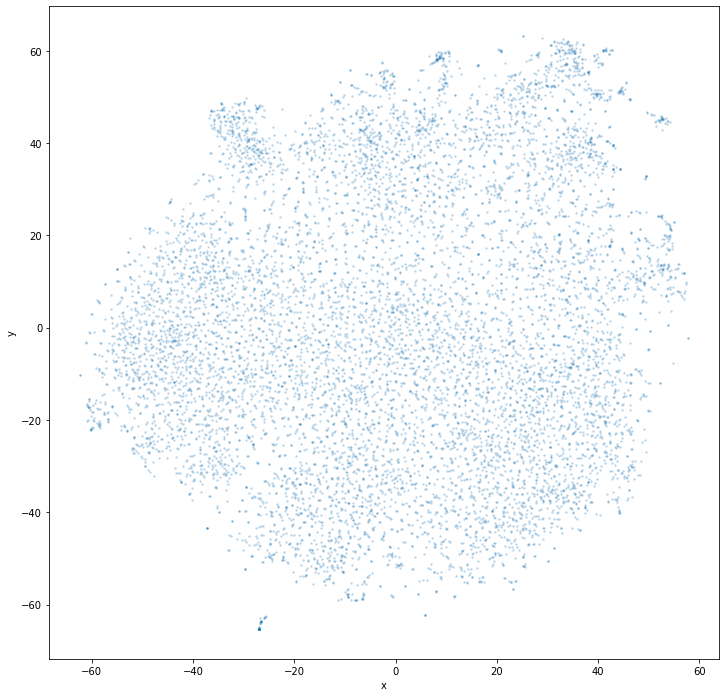

In [57]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12), 
                           marker='.', s=10, alpha=0.2)

In [58]:
output_notebook()

In [59]:
subset_df = coords_df.sample(n=5000)

In [60]:
p = figure(plot_width=800, plot_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)

In [61]:
show(p)